In [ ]:
# If you're in Colab, uncomment these:
!pip install opencv-python shapely pillow matplotlib numpy

In [ ]:
import io
import json
import math
from dataclasses import dataclass
from typing import List, Dict, Any

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import cv2  # type: ignore

In [ ]:
# ==== USER SETTINGS ====

# Path or URL to your pretrained model weights (you will wire this in Cell 6)
MODEL_PATH = "floorplan_model.pth"

# Image processing
IMAGE_MAX_LONG_SIDE = 1024  # px
BINARIZE = True
DESKEW = False  # placeholder flag; deskew function is a no-op by default

# Export options
EXPORT_SVG = True
EXPORT_JSON = True

# Room type mapping (class index -> label)
# Adjust according to your model's class mapping
CLASS_LABELS = {
    0: "background",
    1: "wall",
    2: "door",
    3: "window",
    4: "room_living",
    5: "room_kitchen",
    6: "room_bedroom",
    7: "room_bath"
}

Upload a floor plan image (PNG/JPEG)...


Saving floor-plan-sample-3.webp to floor-plan-sample-3 (1).webp
Loaded image: floor-plan-sample-3 (1).webp


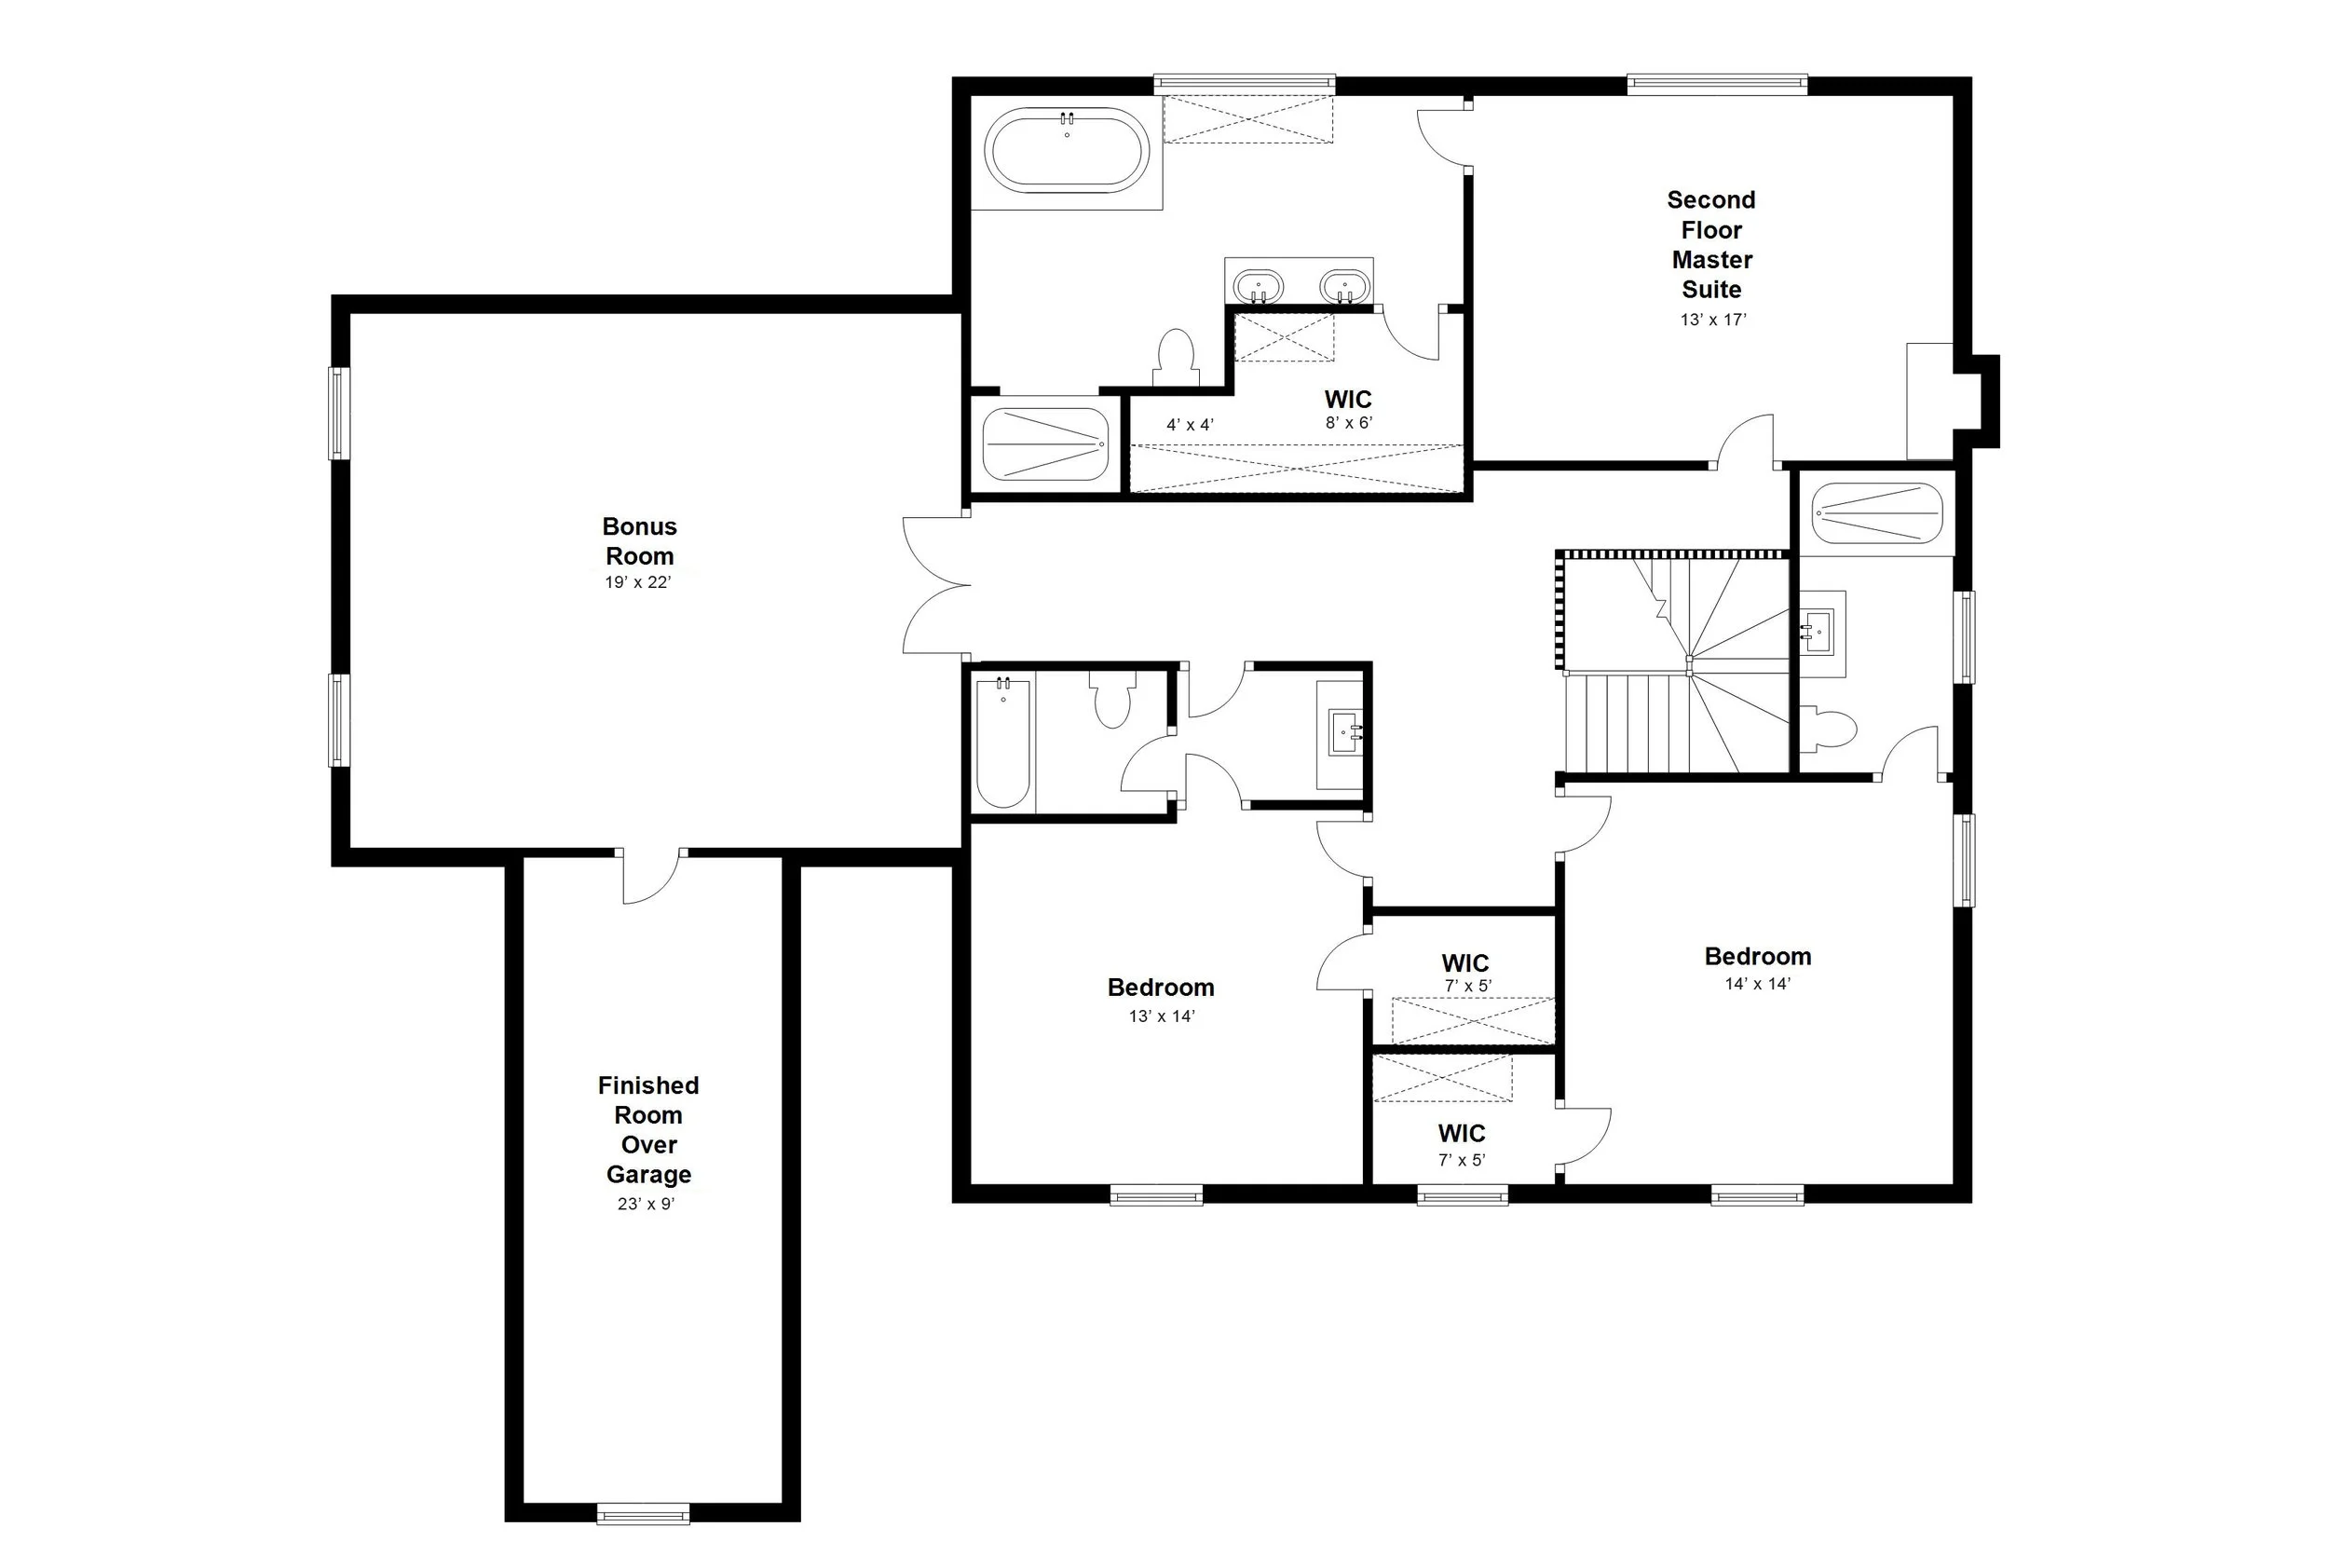

In [ ]:
# For Colab: use files.upload()
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

uploaded_image = None
uploaded_filename = None

if IN_COLAB:
    print("Upload a floor plan image (PNG/JPEG)...")
    uploaded = files.upload()
    if uploaded:
        uploaded_filename = list(uploaded.keys())[0]
        uploaded_image = Image.open(io.BytesIO(uploaded[uploaded_filename])).convert("RGB")
else:
    # If running locally, set a path manually
    uploaded_filename = "example_floorplan.png"  # change this
    uploaded_image = Image.open(uploaded_filename).convert("RGB")

print("Loaded image:", uploaded_filename)
display(uploaded_image)


Re-loaded uploaded_image from kernel state: floor-plan-sample-3 (1).webp
Preprocessed image size: (1024, 689)


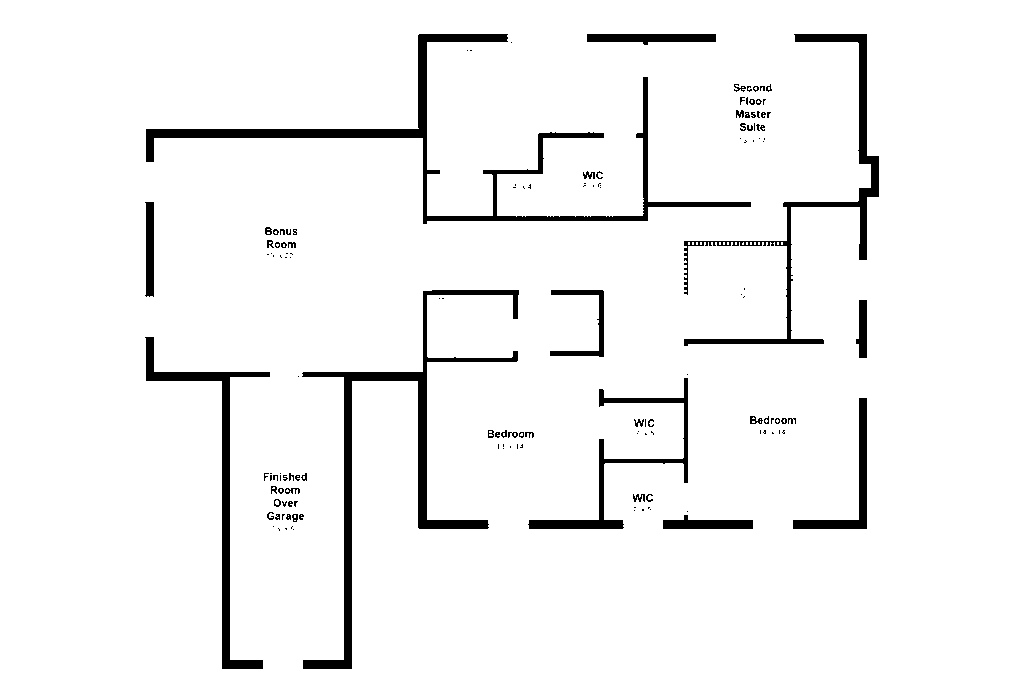

In [ ]:
def resize_longest_side(img: Image.Image, max_long_side: int) -> Image.Image:
    w, h = img.size
    long_side = max(w, h)
    if long_side <= max_long_side:
        return img
    scale = max_long_side / long_side
    new_size = (int(w * scale), int(h * scale))
    return img.resize(new_size, Image.BILINEAR)


def binarize_image(img: Image.Image) -> Image.Image:
    gray = img.convert("L")
    arr = np.array(gray)
    # Otsu threshold
    _, th = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return Image.fromarray(th)


def deskew_image(img: Image.Image) -> Image.Image:
    # Placeholder: no-op. You can implement Hough-based rotation here.
    return img


# Apply preprocessing
# Ensure uploaded_image is always loaded from the raw uploaded bytes if available
# This prevents issues if uploaded_image was not persisted correctly across cells.
if 'uploaded' in globals() and 'uploaded_filename' in globals() and uploaded is not None and uploaded_filename is not None:
    try:
        uploaded_image = Image.open(io.BytesIO(uploaded[uploaded_filename])).convert("RGB")
        print(f"Re-loaded uploaded_image from kernel state: {uploaded_filename}")
    except KeyError:
        print(f"Error: uploaded_filename '{uploaded_filename}' not found in uploaded dictionary in kernel state.")
        uploaded_image = None
    except Exception as e:
        print(f"Error re-loading image from kernel state: {e}")
        uploaded_image = None
else:
    print("Warning: 'uploaded' or 'uploaded_filename' not found in kernel state. Ensure image was uploaded.")
    uploaded_image = None

proc_img = uploaded_image

# Explicit check to handle cases where uploaded_image might still be None
if proc_img is None:
    raise ValueError("No image available for processing. Please ensure an image was uploaded successfully in the previous step.")

proc_img = resize_longest_side(proc_img, IMAGE_MAX_LONG_SIDE)

if BINARIZE:
    proc_img = binarize_image(proc_img)

if DESKEW:
    proc_img = deskew_image(proc_img)

print("Preprocessed image size:", proc_img.size)
display(proc_img)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

NUM_CLASSES = len(CLASS_LABELS)


class DummyFloorPlanModel(nn.Module):
    """
    Placeholder model.
    Replace with your actual architecture and weight loading.
    """

    def __init__(self, num_classes: int = NUM_CLASSES):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, x):
        # x: (B, 3, H, W)
        b, c, h, w = x.shape
        # Random logits (for structure testing only)
        logits = torch.randn(b, self.num_classes, h, w, device=x.device)
        return logits


def load_model(model_path: str) -> nn.Module:
    """
    Replace this with your real model loading logic.
    """
    model = DummyFloorPlanModel(num_classes=NUM_CLASSES)
    # Example for real model:
    # model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()
    return model


device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model(MODEL_PATH).to(device)
print("Model loaded on device:", device)

Model loaded on device: cpu


In [ ]:
def pil_to_tensor(img: Image.Image) -> torch.Tensor:
    arr = np.array(img).astype(np.float32) / 255.0  # H, W, C
    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)
    arr = arr.transpose(2, 0, 1)  # C, H, W
    t = torch.from_numpy(arr)
    return t


@torch.no_grad()
def predict_segmentation(img: Image.Image) -> np.ndarray:
    """
    Returns a 2D array (H, W) of class indices.
    """
    t = pil_to_tensor(img).unsqueeze(0).to(device)  # 1, C, H, W
    logits = model(t)  # 1, num_classes, H, W
    probs = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)
    return pred


seg_mask = predict_segmentation(proc_img)
print("Segmentation mask shape:", seg_mask.shape)

Segmentation mask shape: (689, 1024)


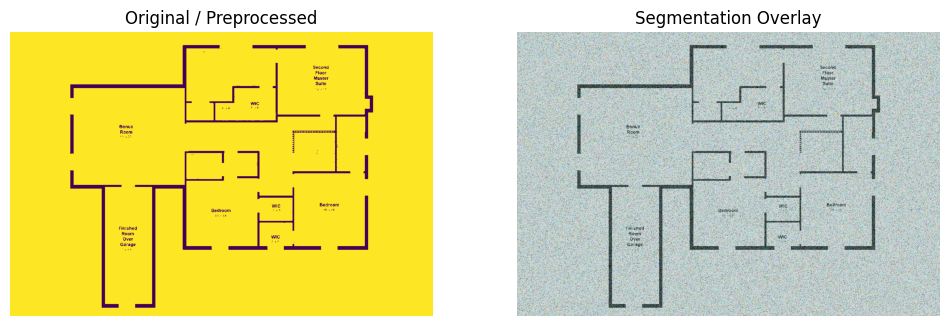

In [ ]:
def colorize_segmentation(mask: np.ndarray, class_labels: Dict[int, str]) -> np.ndarray:
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    rng = np.random.default_rng(42)

    # Assign a random color per class (fixed seed for consistency)
    class_colors = {}
    for cls in class_labels.keys():
        if cls == 0:
            class_colors[cls] = (0, 0, 0)
        else:
            class_colors[cls] = tuple(int(x) for x in rng.integers(50, 255, size=3))

    for cls, color in class_colors.items():
        colored[mask == cls] = color

    return colored


colored_mask = colorize_segmentation(seg_mask, CLASS_LABELS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original / Preprocessed")
plt.imshow(proc_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmentation Overlay")
alpha = 0.5
overlay = (alpha * np.array(proc_img.convert("RGB")) + (1 - alpha) * colored_mask).astype(np.uint8)
plt.imshow(overlay)
plt.axis("off")
plt.show()

In [ ]:
@dataclass
class PolygonFeature:
    points: List[List[float]]  # [[x, y], ...]
    cls: int
    label: str


def mask_to_polygons(mask: np.ndarray, cls_id: int) -> List[PolygonFeature]:
    """
    Extract polygons for a given class id from the segmentation mask.
    """
    binary = (mask == cls_id).astype(np.uint8) * 255
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    polys: List[PolygonFeature] = []
    for cnt in contours:
        if len(cnt) < 3:
            continue
        epsilon = 0.01 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        pts = approx.reshape(-1, 2).tolist()
        polys.append(PolygonFeature(points=pts, cls=cls_id, label=CLASS_LABELS.get(cls_id, str(cls_id))))
    return polys


def build_structure(mask: np.ndarray) -> Dict[str, Any]:
    h, w = mask.shape
    structure: Dict[str, Any] = {
        "image_size": {"width": w, "height": h},
        "walls": [],
        "doors": [],
        "windows": [],
        "rooms": []
    }

    # Walls
    for poly in mask_to_polygons(mask, 1):
        structure["walls"].append({"points": poly.points})

    # Doors
    for poly in mask_to_polygons(mask, 2):
        structure["doors"].append({"points": poly.points})

    # Windows
    for poly in mask_to_polygons(mask, 3):
        structure["windows"].append({"points": poly.points})

    # Rooms (all classes >= 4 treated as rooms)
    room_id = 1
    for cls_id, label in CLASS_LABELS.items():
        if cls_id < 4:
            continue
        for poly in mask_to_polygons(mask, cls_id):
            structure["rooms"].append({
                "id": room_id,
                "points": poly.points,
                "type": poly.label
            })
            room_id += 1

    return structure


vector_structure = build_structure(seg_mask)
print("Walls:", len(vector_structure["walls"]))
print("Doors:", len(vector_structure["doors"]))
print("Windows:", len(vector_structure["windows"]))
print("Rooms:", len(vector_structure["rooms"]))

Walls: 7972
Doors: 8146
Windows: 8046
Rooms: 32282


In [ ]:
def polygon_area(points: List[List[float]]) -> float:
    """
    Shoelace formula. Returns area in pixel^2.
    """
    if len(points) < 3:
        return 0.0
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    area = 0.0
    n = len(points)
    for i in range(n):
        j = (i + 1) % n
        area += x[i] * y[j] - x[j] * y[i]
    return abs(area) / 2.0


for room in vector_structure["rooms"]:
    room["area_px2"] = polygon_area(room["points"])

print("Sample room entries with area:")
for room in vector_structure["rooms"][:5]:
    print(room)

Sample room entries with area:
{'id': 1, 'points': [[967, 687], [967, 688], [968, 688]], 'type': 'room_living', 'area_px2': 0.5}
{'id': 2, 'points': [[937, 687], [936, 687], [935, 688], [934, 688], [935, 688], [936, 687]], 'type': 'room_living', 'area_px2': 0.0}
{'id': 3, 'points': [[662, 687], [662, 688], [663, 688]], 'type': 'room_living', 'area_px2': 0.5}
{'id': 4, 'points': [[616, 687], [617, 688], [618, 688], [617, 688]], 'type': 'room_living', 'area_px2': 0.0}
{'id': 5, 'points': [[411, 687], [412, 687], [413, 688], [414, 688], [413, 688], [412, 687]], 'type': 'room_living', 'area_px2': 0.0}


In [ ]:
def structure_to_svg(structure: Dict[str, Any], scale: float = 1.0) -> str:
    w = structure["image_size"]["width"]
    h = structure["image_size"]["height"]

    def pts_to_path(points: List[List[float]]) -> str:
        if not points:
            return ""
        cmds = [f"M {points[0][0]*scale:.2f},{points[0][1]*scale:.2f}"]
        for x, y in points[1:]:
            cmds.append(f"L {x*scale:.2f},{y*scale:.2f}")
        cmds.append("Z")
        return " ".join(cmds)

    svg_parts = [
        f'<svg xmlns="http://www.w3.org/2000/svg" width="{w*scale:.2f}" height="{h*scale:.2f}" viewBox="0 0 {w*scale:.2f} {h*scale:.2f}">'
    ]

    # Walls
    for wall in structure["walls"]:
        path = pts_to_path(wall["points"])
        svg_parts.append(f'<path d="{path}" fill="none" stroke="black" stroke-width="2"/>')

    # Doors
    for door in structure["doors"]:
        path = pts_to_path(door["points"])
        svg_parts.append(f'<path d="{path}" fill="none" stroke="blue" stroke-width="1.5"/>')

    # Windows
    for window in structure["windows"]:
        path = pts_to_path(window["points"])
        svg_parts.append(f'<path d="{path}" fill="none" stroke="cyan" stroke-width="1.5"/>')

    # Rooms (light fill)
    for room in structure["rooms"]:
        path = pts_to_path(room["points"])
        svg_parts.append(f'<path d="{path}" fill="#f2f2f2" stroke="#888" stroke-width="1"/>')

    svg_parts.append("</svg>")
    return "\n".join(svg_parts)


svg_str = structure_to_svg(vector_structure, scale=1.0)

# Save to file
svg_filename = (uploaded_filename or "floorplan").rsplit(".", 1)[0] + "_vector.svg"
with open(svg_filename, "w", encoding="utf-8") as f:
    f.write(svg_str)

print("SVG saved as:", svg_filename)

SVG saved as: floor-plan-sample-3 (1)_vector.svg


In [ ]:
json_filename = (uploaded_filename or "floorplan").rsplit(".", 1)[0] + "_vector.json"

with open(json_filename, "w", encoding="utf-8") as f:
    json.dump(vector_structure, f, indent=2)

print("JSON saved as:", json_filename)

JSON saved as: floor-plan-sample-3 (1)_vector.json


In [ ]:
from pprint import pprint

room_summary = [
    {
        "id": r["id"],
        "type": r["type"],
        "area_px2": round(r.get("area_px2", 0.0), 1)
    }
    for r in vector_structure["rooms"]
]

pprint(room_summary[:10])

[{'area_px2': 0.5, 'id': 1, 'type': 'room_living'},
 {'area_px2': 0.0, 'id': 2, 'type': 'room_living'},
 {'area_px2': 0.5, 'id': 3, 'type': 'room_living'},
 {'area_px2': 0.0, 'id': 4, 'type': 'room_living'},
 {'area_px2': 0.0, 'id': 5, 'type': 'room_living'},
 {'area_px2': 0.0, 'id': 6, 'type': 'room_living'},
 {'area_px2': 0.0, 'id': 7, 'type': 'room_living'},
 {'area_px2': 0.5, 'id': 8, 'type': 'room_living'},
 {'area_px2': 0.5, 'id': 9, 'type': 'room_living'},
 {'area_px2': 0.0, 'id': 10, 'type': 'room_living'}]
